In [25]:
from simulator import Sim
from strategy import BestPosStrategy
from get_info import get_pnl
from load_data import load_md_from_file

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
from typing import List, Optional, Tuple, Union, Dict
import math
from simulator import MdUpdate, Order, OwnTrade, Sim, update_best_positions
import bisect
import seaborn as sns
from collections import defaultdict, deque
import random
from math import e, sqrt, log, pi

#### Введение

В этой работе мы возьмем наивный про рата алгоритм который ставит свои заявки на бест уровнях. Мы понимаем, что он будет плохо конролировать свой инвентори.

Далее, в сеттинге где я могу ставит свои ордера только на бест уровнях, но с разными обьемами, я нахожу аналитические формулы для обьемов, которые будут контролировать инвентори like a boss. Точнее, это будет процесс чье инвентори при T->inf будет следовать нормальному распределению. То есть, стационарные вероятности процесса инвентори будет нормальным. Количество пересечений нуля не подсчитывается в явном виде, однако на графике будет четко видно, что это происходит значительно чаще чем у наивного алгоритма.

Мой средний шаг в инвентори будет равен ~0.1 btc. Инвентори строго ограничивается 10 btc, однако 3 sigma интервал для инвентори будет в районе (-2.1, 2.1). 

Ключивое предположение в моих выкладках, это то, что на бест уровнях нас испольняют с одинкавой частотой. Значит, если мы ставим обьемы v_up, v_down. То, с вероятностями 0.5 идем вверх на v_up и вниз на v_down в нашем инвентори процессе.

Кульминация результата в конце ноутбука, там сравниваются графики инвентори моего и наивного алгоритма.

In [84]:
"""
    Хелпер функции, вычисляющие обьемы на бест уровнях, при заданной инвентори.
"""

limit = 10
step = 0.1
base = 1000

def p(s):
    return (limit + s) / (2 * limit)

def round_base(x):
    return round(base * x) / base

def volumes(s):
    ps = p(s)
    mu = (1 - 2 * ps)
    sigma = 2 * sqrt(ps - ps ** 2)

    vu = step * (sigma + mu)
    vd = step * (sigma - mu)

    return round_base(vu), round_base(vd)

[(-28, 1), (-27, 7), (-26, 10), (-25, 8), (-24, 23), (-23, 48), (-22, 73), (-21, 117), (-20, 163), (-19, 210)]


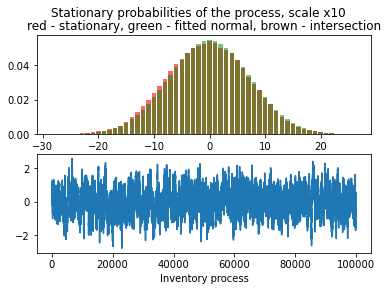

In [85]:
"""
    Симуляция того, что с одинаковыми вероятностями нас исполняют либо на биде, либо на аске. 
    Визуализируем графики инвентори со временем и cтационарные вероятности нашего процесса.
"""

def coin():
    return random.randrange(0, 2)

def fit_normal(states, counts):
    var = sum(s ** 2 * c / N for s, c in zip(states, counts))
    return [e ** (-s**2 / (2 * var)) / sqrt(2 * pi * var) for s in states]


pos = 0
N = 10 ** 5
ct = defaultdict(int)
positions = []
time = []

for _ in range(N):
    vu, vd = volumes(pos)
    is_up = coin()

    if is_up:
        pos += vu
    else:
        pos -= vd

    ct[round(pos * 10)] += 1
    time.append(_)
    positions.append(pos)


ls = sorted(ct.items())
print(ls[:10])

states, counts = zip(*ls)

hs = fit_normal(states, counts)

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Stationary probabilities of the process, scale x10')
ax1.set_title('red - stationary, green - fitted normal, brown - intersection')
ax2.set(xlabel='Inventory process')

ax1.bar(states, height=[c / N for c in counts], color='r', alpha=0.6)
ax1.bar(states, height=hs, color='g', alpha=0.5)
ax2.plot(time, positions)

plt.show()

In [26]:
"""
    Load data
"""

Tsmall = pd.Timedelta(20, 'm').delta
T6h = pd.Timedelta(6, 'h').delta
Tlrg = pd.Timedelta(25, 'h').delta
PATH_TO_FILE = '../md/btcusdt_Binance_LinearPerpetual/'

md_small = load_md_from_file(path=PATH_TO_FILE, T = Tsmall)
md_6h = load_md_from_file(path=PATH_TO_FILE, T = T6h)
md_large = load_md_from_file(path=PATH_TO_FILE, T = Tlrg)

In [27]:
"""
    Взял у Долматова вычисление бест уровней.
"""

def update_best_positions(best_bid:float, best_ask:float, md:MdUpdate) -> Tuple[float, float]:
    if not md.orderbook is None:
        best_bid = md.orderbook.bids[0][0]
        best_ask = md.orderbook.asks[0][0]
    elif not md.trade is None:
        if md.trade.side == 'BID':
            best_ask = max(md.trade.price, best_ask)
        elif md.trade.side == 'ASK':
            best_bid = min(best_bid, md.trade.price)
        else:
            assert False, "WRONG TRADE SIDE"
    assert best_ask > best_bid, "wrong best positions"
    return best_bid, best_ask

In [97]:
class NaiveProRata:
    def __init__(self, delay_orders = 0.1, thr_one_side = 4, order_size = 0.1) -> None:
        # hyper-parameters
        self.delay_orders = pd.Timedelta(delay_orders, 's').delta
        self.market_latency = pd.Timedelta(11, 'ms').delta
        self.lim1 = thr_one_side
        
        # parameters
        self.order_size = order_size
        self.q = 0
        self.last_order_ts = 0
        self.comission = 0.0001
        self.rebate = 0
        
        # constants
        self.INF = 10 ** 9
        self.NO_ORDER = 10 ** 9
        
        # statistics
        self.ask_vol = 0
        self.bid_vol = 0

        
    def ask_bid(self, best_ask, best_bid):
        price_ask, price_bid = best_ask, best_bid
        # LIGHT RED. Only limit order at ASK
        if self.q >= self.lim1:
            price_ask = best_ask
            price_bid = self.NO_ORDER
        
        # LIGHT GREEN. Only limit order at BID
        elif self.q <= -self.lim1:
            price_ask = self.NO_ORDER
            price_bid = best_bid
                
        return price_ask, price_bid
    
    
    def place_ask(self, receive_ts, order_size, ask):
        ask_order = sim.place_order(receive_ts, order_size, 'ASK', ask)
        self.ongoing_orders[ask_order.order_id] = ask_order

    
    def place_bid(self, receive_ts, order_size, bid):
        bid_order = sim.place_order(receive_ts, order_size, 'BID', bid)
        self.ongoing_orders[bid_order.order_id] = bid_order
        
        
    def cancel_trades(self, receive_ts):
        # cancel current limit orders
        for ID, order in list(self.ongoing_orders.items()):
            sim.cancel_order(receive_ts, ID)
            self.ongoing_orders.pop(ID)
        
    
    def do_trade(self, receive_ts, best_bid, best_ask):
        if best_ask == self.INF:
            return
        self.last_order_ts = receive_ts

        # place new orders on current reservation price and spread
        ask, bid = self.ask_bid(best_bid, best_ask)
        
        if ask != self.NO_ORDER:
            self.place_ask(receive_ts, self.order_size, ask)
        
        if bid != self.NO_ORDER:
            self.place_bid(receive_ts, self.order_size, bid)
            

    def run(self, sim: Sim) -> List[Union[OwnTrade, MdUpdate]]:
        updates_list = []
        self.ongoing_orders: Dict[int, Order] = {}
        best_bid, best_ask = -self.INF, self.INF
        
        while True:
            receive_ts, updates = sim.tick()
            if updates is None: break
            updates_list += updates
            
            for update in updates:
                if isinstance(update, MdUpdate):
                    best_bid, best_ask = update_best_positions(best_bid, best_ask, update)
                    
                elif isinstance(update, OwnTrade):
                    if update.side == 'ASK':
                        self.q -= update.size
                        self.ask_vol += update.size
                        self.rebate += update.price * update.size * self.comission
                        
                    if update.side == 'BID':
                        self.q += update.size
                        self.bid_vol += update.size
                        self.rebate += update.price * update.size * self.comission
                    
                    if update.order_id in self.ongoing_orders.keys():
                        self.ongoing_orders.pop(update.order_id)
                        
                    # we want to place a new order, when old one is executed
                    # but we still wait for market latency from last order
                    if receive_ts - self.last_order_ts >= self.market_latency:
                        self.do_trade(receive_ts, best_bid, best_ask)
                else:
                    assert False, 'invalid type of update!'
            
            # Cancel old trades, right before placing new ones
            if receive_ts - self.last_order_ts >= self.delay_orders - self.market_latency:
                self.cancel_trades(receive_ts)
            
            if receive_ts - self.last_order_ts >= self.delay_orders:
                self.do_trade(receive_ts, best_bid, best_ask)
                
        return updates_list

In [96]:
class InventoryControl:
    def __init__(self, delay_orders = 0.1) -> None:
        # hyper-parameters
        self.delay_orders = pd.Timedelta(delay_orders, 's').delta
        self.market_latency = pd.Timedelta(11, 'ms').delta
        
        # parameters
        self.q = 0
        self.last_order_ts = 0
        self.comission = 0.0001
        self.rebate = 0
        
        # constants
        self.INF = 10 ** 9
        
        # statistics
        self.ask_vol = 0
        self.bid_vol = 0
    
    
    def place_ask(self, receive_ts, order_size, ask):
        ask_order = sim.place_order(receive_ts, order_size, 'ASK', ask)
        self.ongoing_orders[ask_order.order_id] = ask_order

    
    def place_bid(self, receive_ts, order_size, bid):
        bid_order = sim.place_order(receive_ts, order_size, 'BID', bid)
        self.ongoing_orders[bid_order.order_id] = bid_order
        
        
    def cancel_trades(self, receive_ts):
        # cancel current limit orders
        for ID, order in list(self.ongoing_orders.items()):
            sim.cancel_order(receive_ts, ID)
            self.ongoing_orders.pop(ID)
        
    
    def do_trade(self, receive_ts, best_bid, best_ask):
        if best_ask == self.INF:
            return
        self.last_order_ts = receive_ts

        # place new orders of given volume
        bid_vol, ask_vol = volumes(self.q)
        
        self.place_ask(receive_ts, ask_vol, best_ask)
        self.place_bid(receive_ts, bid_vol, best_bid)
            

    def run(self, sim: Sim) -> List[Union[OwnTrade, MdUpdate]]:
        updates_list = []
        self.ongoing_orders: Dict[int, Order] = {}
        best_bid, best_ask = -self.INF, self.INF
        
        while True:
            receive_ts, updates = sim.tick()
            if updates is None: break
            updates_list += updates
            
            for update in updates:
                if isinstance(update, MdUpdate):
                    best_bid, best_ask = update_best_positions(best_bid, best_ask, update)
                    
                elif isinstance(update, OwnTrade):
                    if update.side == 'ASK':
                        self.q -= update.size
                        self.ask_vol += update.size
                        self.rebate += update.price * update.size * self.comission
                        
                    if update.side == 'BID':
                        self.q += update.size
                        self.bid_vol += update.size
                        self.rebate += update.price * update.size * self.comission
                    
                    if update.order_id in self.ongoing_orders.keys():
                        self.ongoing_orders.pop(update.order_id)
                        
                    # we want to place a new order, when old one is executed
                    # but we still wait for market latency from last order
                    if receive_ts - self.last_order_ts >= self.market_latency:
                        self.do_trade(receive_ts, best_bid, best_ask)
                else:
                    assert False, 'invalid type of update!'
            
            # Cancel old trades, right before placing new ones
            if receive_ts - self.last_order_ts >= self.delay_orders - self.market_latency:
                self.cancel_trades(receive_ts)
            
            if receive_ts - self.last_order_ts >= self.delay_orders:
                self.do_trade(receive_ts, best_bid, best_ask)
                
        return updates_list

In [105]:
"""
    Convinient to change sizes of dataset
"""

# md_run = md_large
md_run = md_6h
# md_run = md_small

In [106]:
"""
    Running the strategy
"""

models = [NaiveProRata(), InventoryControl()]
pnl_xs, pnl_ys, inv_xs, inv_ys = [], [], [], []
all_cps = []


for strategy in models:
    latency = pd.Timedelta(10, 'ms').delta
    sim = Sim(md_run, latency, latency)

    print('\nRunning: ', strategy.__class__.__name__)

    updates_list = strategy.run(sim)
    receive_ts, worth_list, btc_pos_list, mid_price_list = get_pnl(updates_list)

    # Print statistics 
    pnl = worth_list[-1] - worth_list[0]

    print('PNL without commisions in USD:', pnl)
    print('PNL with comissions in USD:', strategy.rebate)
    print('Volume ask in btc', strategy.ask_vol)
    print('Volume bid in btc', strategy.bid_vol)

    # save stats for plots
    dt = pd.to_datetime(receive_ts)
    pnl_xs.append(dt)
    pnl_ys.append(worth_list)

    inv_xs.append(dt)
    inv_ys.append(btc_pos_list)


Running:  NaiveProRata
PNL without commisions in USD: -5193.509999954853
PNL with comissions in USD: 100884.72547450608
Volume ask in btc 24823.099999919268
Volume bid in btc 24823.399999919264

Running:  InventoryControl
PNL without commisions in USD: -13961.431250003345
PNL with comissions in USD: 70941.5126282551
Volume ask in btc 17458.834999996194
Volume bid in btc 17459.043999997226


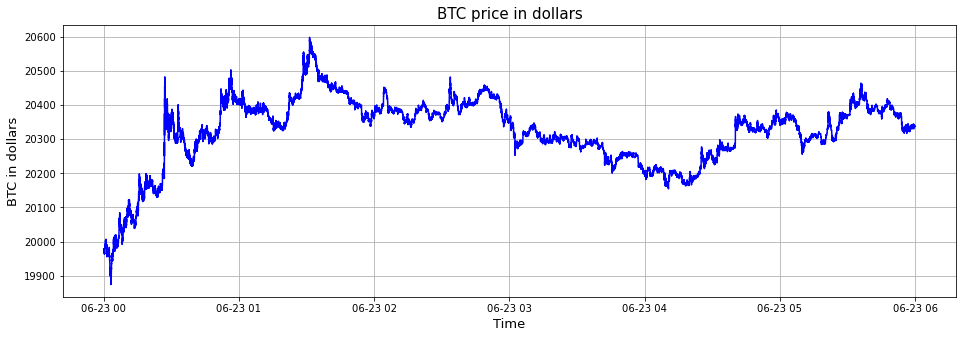

In [107]:
"""
    Plot BTC price 
"""

crs = ['#9f0f0f', 'g', 'b', 'y', 'c', 'gray', 'm']
plt.figure(figsize=(16, 5))
plt.plot(dt, mid_price_list, '-', color = crs[2])

plt.xlabel("Time", fontsize=13)
plt.ylabel("BTC in dollars", fontsize=13)
plt.title("BTC price in dollars", fontsize=15)

# plt.legend(loc='lower left')
plt.grid()
plt.show()

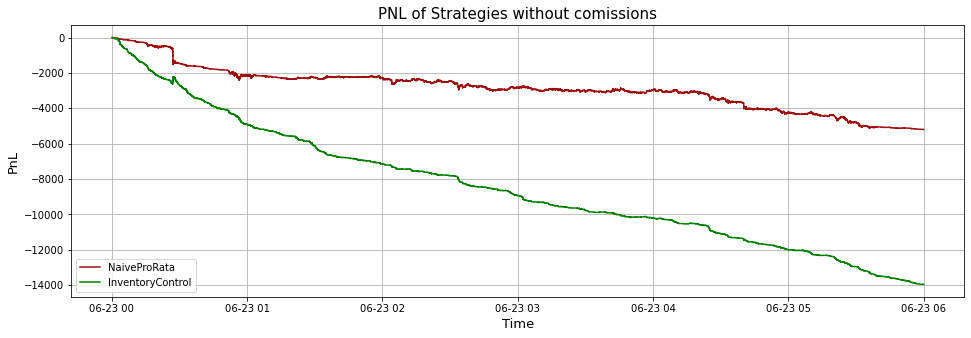

In [110]:
"""
    Plot pnl
"""

crs = ['#9f0f0f', 'g', 'b', 'y', 'c', 'gray', 'm']
plt.figure(figsize=(16, 5))
for i, strategy in enumerate(models):
    plt.plot(pnl_xs[i], pnl_ys[i], '-', color = crs[i], label = strategy.__class__.__name__)

plt.xlabel("Time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("PNL of Strategies without comissions", fontsize=15)

plt.legend(loc='lower left')
plt.grid()
plt.show()

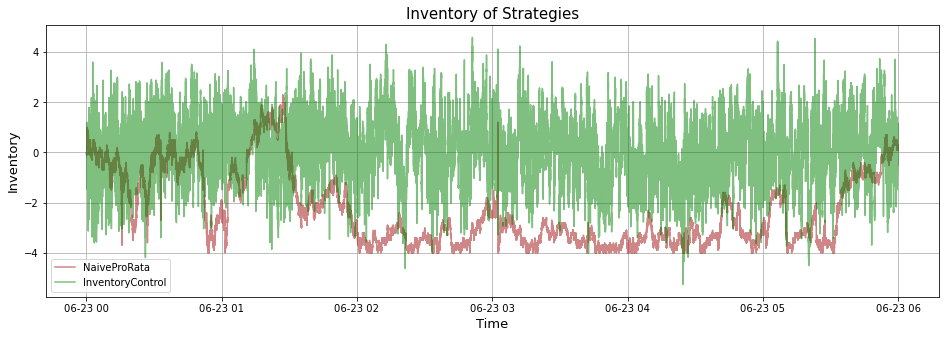

In [109]:
plt.figure(figsize=(16, 5))
for i, strategy in enumerate(models):
    plt.plot(inv_xs[i], inv_ys[i], '-', color = crs[i], label = strategy.__class__.__name__, alpha=0.5)

plt.xlabel("Time", fontsize=13)
plt.ylabel("Inventory", fontsize=13)
plt.title("Inventory of Strategies", fontsize=15)

plt.legend(loc='lower left')
plt.grid()
plt.show()

#### Заключение

Это успешный успех, я научился контролировать свой инвентори, даже на самом наивном алгоритме который ставит заявки на бест уровнях. Мы использовали оптимистичный вариант симулятора, где маркет ордер пересекает нас не строго для испольнения. 

Мы провели огромный обьем сделок, за счет чего, получили большой положительный PNL. Также, по графику инвентори видно что мы контролируем его как боссы. В то время, как наивный алгоритм хоть и делает большой PNL, но может часами держать инвентори по одну сторону от нуля.